In [4]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [9]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('/content/drive/MyDrive/Image_Processing/Lab3_1/fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)

In [10]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [11]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4245, 4182, 4214, 4202, 4195, 4123, 4189, 4142, 4295, 4213]
test groups: [1755, 1818, 1786, 1798, 1805, 1877, 1811, 1858, 1705, 1787]


In [65]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize) # три випадкові групи
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx] # три випадкові групи, які точно не group_idx
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]

    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

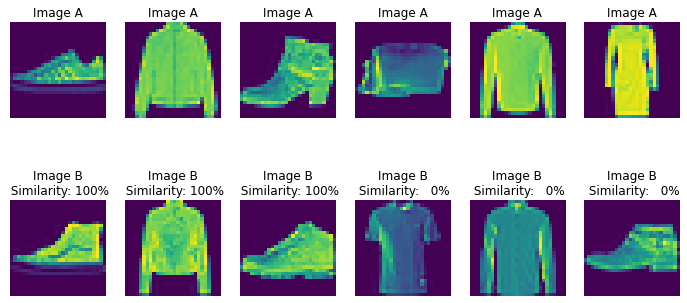

In [66]:
# pv_a це 6 картинок де групи перших трьох і наступних трьох попарно однакові напр. такі групи [9, 4, 1, 9, 4, 1]
# pv_b це 6 картинок де групи перших трьох і наступних трьох попарно різні    напр. такі групи [9, 4, 1, 2, 3, 5]
# pv_sim познача чи однакові групи чи ні                                                       [1, 1, 1, 0, 0, 0]
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:, :, 0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:, :, 0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [67]:
lenet_5 = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=x_train[0].shape, padding='same'), #C1
    keras.layers.AveragePooling2D(), #S2
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    keras.layers.AveragePooling2D(), #S4
    keras.layers.Flatten(), #Flatten
    keras.layers.Dense(120, activation='tanh'), #C5
    keras.layers.Dense(84, activation='tanh'), #F6
    keras.layers.Dense(10, activation='softmax') #Output layer
])

In [79]:
x_train.shape[1:]

(28, 28, 1)

In [68]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = lenet_5(img_a_in)
img_b_feat = lenet_5(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 10)           61706       ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['sequential_2[0][

In [82]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

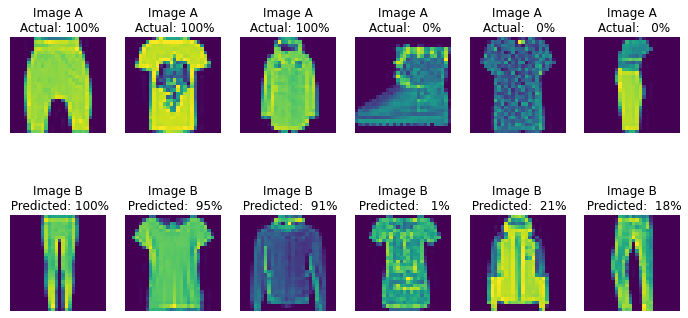

In [84]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

_ = show_model_output()

In [80]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
                                              steps_per_epoch=500,
                                              validation_data=(
                                                  [valid_a, valid_b], valid_sim),
                                              epochs=25,
                                              verbose=True)

Epoch 1/25
  2/500 [..............................] - ETA: 33s - loss: 0.1534 - mae: 0.1059

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


500/500 [==============================] - 41s 81ms/step - loss: 0.1882 - mae: 0.1135 - val_loss: 0.2141 - val_mae: 0.1162
Epoch 2/25
500/500 [==============================] - 35s 70ms/step - loss: 0.1928 - mae: 0.1162 - val_loss: 0.2029 - val_mae: 0.1096
Epoch 3/25
500/500 [==============================] - 34s 69ms/step - loss: 0.1924 - mae: 0.1161 - val_loss: 0.2019 - val_mae: 0.1137
Epoch 4/25
500/500 [==============================] - 35s 69ms/step - loss: 0.1832 - mae: 0.1118 - val_loss: 0.1986 - val_mae: 0.1068
Epoch 5/25
500/500 [==============================] - 35s 70ms/step - loss: 0.1883 - mae: 0.1132 - val_loss: 0.1946 - val_mae: 0.1050
Epoch 6/25
500/500 [==============================] - 35s 70ms/step - loss: 0.1877 - mae: 0.1124 - val_loss: 0.1874 - val_mae: 0.1081
Epoch 7/25
500/500 [==============================] - 35s 70ms/step - loss: 0.1864 - mae: 0.1134 - val_loss: 0.1935 - val_mae: 0.1123
Epoch 8/25
500/500 [==============================] - 35s 70ms/step - los

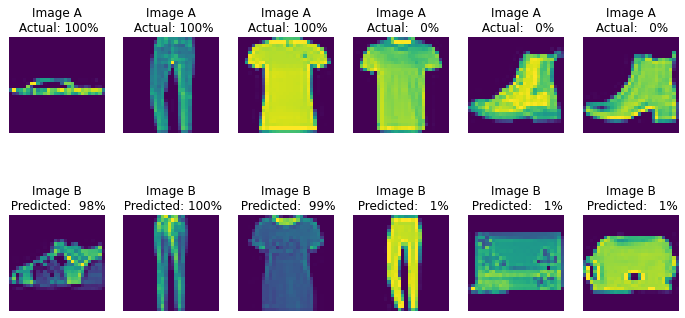

In [72]:
_ = show_model_output()

In [88]:
x_test_features = lenet_5.predict(x_test, verbose = True,batch_size=128)

141/141 [==============================] - 6s 45ms/step


In [76]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.029s...
[t-SNE] Computed neighbors for 18000 samples in 0.956s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 82.9282532, gradient norm = 0.0033852 (50 iterations in 7.718s)
[t-SNE] Iteration 100: error = 76.4275208, gradient norm = 0.0022786 (50 iterations in 7.397s)
[t-SNE] Iteration 150: error = 73.5636520, gradient norm = 0.0015509 (50 iterations in 7.470s)
[t-SNE] Iteration 200: error = 71.9088745, gradient norm = 0.0011718 (50 iterations in 7.423s)
[t-SNE] Iteration 250: error = 70.8097763, gradient norm = 0.0009314 (50 iterations in 7.421s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.809776
[t-SNE] Iteration 300: error = 2.8851895, gradient norm = 0.0011903 (50 iterations in 7.647s)
[t-SNE] Iteration 350: error = 2.3352683, gradient norm = 0.0006800 (50 iterations in 7.561s)
[t-SNE] Iteration 400: error = 1.9644449, gradient norm = 0.0004406 (50 iterations in 7.493s)
[t-SNE] Iteration 450: error = 1.7232594, gradient norm = 0.0003114 (50 iterations in 7.391s)
[t-SNE] Iteration 500: error = 1.5559690, gradient norm = 0.0002352 (50 

In [85]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(20, 20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

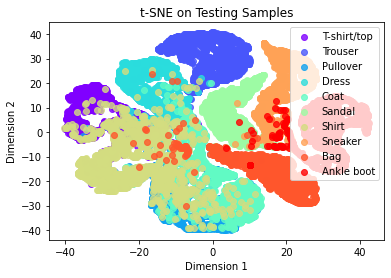

In [87]:
import matplotlib.pyplot as plt
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/Image_Processing/Lab3_1/clothes-dist.png')
plt.show(block=False)